##Textual Analysis of Communications in COVID-19 Infected Community on Social Media

In this notebook, we focus on one of the subreddit *r/COVID19positive*, on which people discussed pandemic related questions and shared their experience. Thanks to the self-reported flairs provided by most users' submissions on Reddit, it serves as perfect labeling system for our dataset. We would like to formulate a multi-label classification problem so that our model can automatically provides a tag for user's submission and post. 

Our model will be a BERT-based classification model because of the limited sample size. Dataset will be split into train-validation-test sets with a 70-15-15 ratio. We will fine tune the pre-trained BERT model, and adopt early stopping technique to prevent overfitting, and finally evaluate the model performance based on accuracy.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("train.tsv", delimiter='\t')
val_data = pd.read_csv("val.tsv", delimiter='\t')
test_data = pd.read_csv("test.tsv", delimiter='\t')

### Data Preparation

Since most submissions have a title and body, and both of them contain informative texts for our classification. We concatenate them together into 'titletext' and use this column to make the prediction. There are three categories, which are **questions, presumed_positive, positive**, and the label mapping is: {
    questions: 0, 
    presumed_positive: 1, 
    tested_positive: 2
}. 

In [3]:
train_data.head()

,title,text,titletext,label
0,Ongoing dry nose and yellow boogers since arou...,[removed],Ongoing dry nose and yellow boogers since arou...,0
1,Requesting help,"I started feeling ill June 19, I got tested 2 ...","Requesting help I started feeling ill June 19,...",2
2,What do you think of my moms symptoms. Should ...,So a week ago my mom vomited twice unexplainab...,What do you think of my moms symptoms. Should ...,0
3,How should I prepare as a single person,Hi All. I’m single and live alone. All my fami...,How should I prepare as a single person Hi All...,0
4,How long were yall testing positive ?,Im at day 25 pretty much asymptomatic . Only t...,How long were yall testing positive ? Im at da...,2


In [5]:
train_data = train_data.drop(columns = ['title', 'text']) \
            .rename(columns = {'titletext':'text'})
test_data = test_data.drop(columns = ['title', 'text']) \
            .rename(columns = {'titletext':'text'})
val_data = val_data.drop(columns = ['title', 'text']) \
            .rename(columns = {'titletext': 'text'})

In [6]:
train_data.head()

,text,label
0,Ongoing dry nose and yellow boogers since arou...,0
1,"Requesting help I started feeling ill June 19,...",2
2,What do you think of my moms symptoms. Should ...,0
3,How should I prepare as a single person Hi All...,0
4,How long were yall testing positive ? Im at da...,2


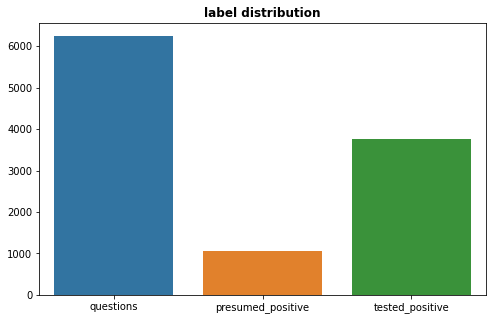

In [89]:
import seaborn as sns

plt.figure(figsize=(8, 5))
label_dist = train_data['label'].value_counts()
sns.barplot(x = label_dist.index, y = label_dist.values)
plt.xticks(ticks=[0, 1, 2], labels = ['questions', 'presumed_positive', 'tested_positive'])
plt.title('label distribution', weight='bold')
plt.show()

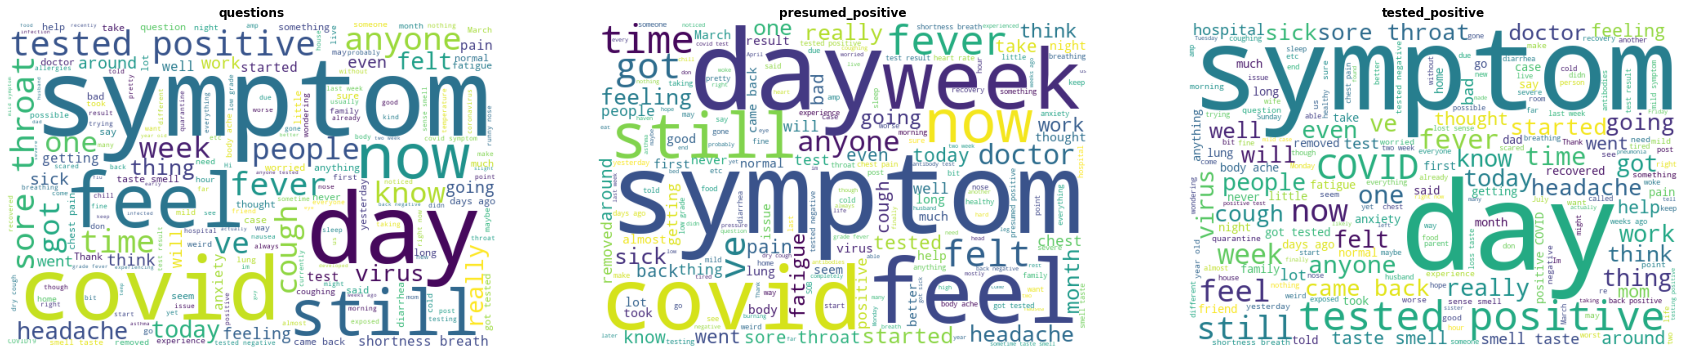

In [90]:
questions = train_data.loc[train_data['label'] == 0]['text']
presumed_positive = train_data.loc[train_data['label'] == 1]['text']
tested_positive = train_data.loc[train_data['label'] == 2]['text']

from wordcloud import WordCloud

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
wordcloud1 = WordCloud(background_color = 'white', width=600, height=400).generate(" ".join(questions))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title("questions", weight='bold')

wordcloud2 = WordCloud(background_color = 'white', width=600, height=400).generate(" ".join(presumed_positive))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title("presumed_positive", weight='bold')

wordcloud3 = WordCloud(background_color = 'white', width=600, height=400).generate(" ".join(tested_positive))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title("tested_positive", weight='bold')

plt.show()

### WordCloud
From the wordcloud, although three of them look similar, but there's some minor differenec between them. For example, in the first two wordclouds, there some some dominant words that appear less often in the third wordcloud, for example, words like "still", "now", "feel" are extremely salient in the first two plots but not the third, which probably indicates the uncertainty and anxious feeling of the first two groups of people. 

### BERT Training

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [8]:
def preprocessing(sent):
    sent = sent.replace('[removed]', '')
    
    sent = " ".join([word.strip() for word in sent.split()])
    
    return sent

In [9]:
train_data['text'][0]

'Ongoing dry nose and yellow boogers since around day 1? [removed]'

In [10]:
preprocessing(train_data['text'][0])

'Ongoing dry nose and yellow boogers since around day 1?'

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('running on GPU')
else:
    device = torch.device('cpu')
    print('running on CPU')

running on GPU


In [12]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 890kB 29.2MB/s 
     |████████████████████████████████| 2.9MB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d6cee7d377199be43d0a00a09d633c0181085a908bc5b3404472f2fdfeb0a4b9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [13]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [14]:
def preprocessing_bert(data):
    input_ids = []
    attention_masks = []
    
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = preprocessing(sent),
            add_special_tokens = True,
            truncation = True,
            max_length = 400,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        
        input_ids.append(encoded_sent['input_ids'])
        attention_masks.append(encoded_sent['attention_mask'])
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [15]:
X_train = train_data['text'].values
y_train = train_data['label'].values
X_val = val_data['text'].values
y_val = val_data['label'].values
X_test = test_data['text'].values
y_test = test_data['label'].values

In [92]:
train_inputs, train_masks = preprocessing_bert(X_train)
val_inputs, val_masks = preprocessing_bert(X_val)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [95]:
print("Shape")
print("-"*55)
print(f"{'Train_inputs':^25} | {'Train_masks':^25} | {'Val_inputs':^25} | {'Val_masks':^25}")
print(f"{train_inputs.shape} | {train_masks.shape} | {val_inputs.shape} | {val_masks.shape}")

Shape
-------------------------------------------------------
      Train_inputs        |        Train_masks        |        Val_inputs         |         Val_masks        
torch.Size([11073, 400]) | torch.Size([11073, 400]) | torch.Size([2769, 400]) | torch.Size([2769, 400])


In [36]:
train_labels, val_labels = torch.tensor(y_train), torch.tensor(y_val)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

batch_size = 16

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [37]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, freeze_bert = False):
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 3
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        
        if freeze_bert:
            for param in self.bert.parameters():
                param.require_grad = False
    
    def forward(self, input_ids, attention_masks):
        output = self.bert(input_ids = input_ids, attention_mask = attention_masks)
        
        last_hidden_state_cls = output[0][:, 0, :]
        
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [41]:
from transformers import AdamW

def initialize_model(epochs = 5):
    bert_classifier = BertClassifier(freeze_bert = False)
    bert_classifier.to(device)
    
    optimizer = AdamW(bert_classifier.parameters(), 
                     lr = 5e-5,
                     eps = 1e-8)
    
    return bert_classifier, optimizer

In [75]:
#weights = torch.FloatTensor([0.15, 0.25, 0.6]).to(device)
#criterion = nn.CrossEntropyLoss(weight = weights)

In [79]:
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, val_loader=None, epochs = 5, evaluation=False):
    print("Start Training...")
    min_loss, early_stopping_cnt = 1, 0
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^10}")
        
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_loader):
            batch_counts += 1
            
            b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)
            
            model.zero_grad()
            
            logits = model(b_input_ids, b_attention_mask)
            
            loss = criterion(logits, b_labels)
            batch_loss += loss
            total_loss += loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            if (step % 20 == 0 and step != 0) or (step == len(train_loader) - 1):
                print(f"{epoch_i+1:^7} | {step:^7} | {batch_loss/batch_counts:^12.6f} | {'-':^10} | {'-':^10}")
                batch_loss, batch_counts = 0, 0

            #evaluate the performance on validation set every 100 batches
            if evaluation == True:
                if (step % 100 == 0 and step != 0) or (step == len(train_loader) - 1):
                    avg_train_loss = total_loss/step

                    print('-'*70)

                    val_loss, val_accuracy = [], []
                    model.eval()
                    
                    for step, batch in enumerate(val_loader):
                        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)
                        
                        with torch.no_grad():
                            logits = model(b_input_ids, b_attention_mask)
                        
                        loss = criterion(logits, b_labels)
                        val_loss.append(loss.item())
                        
                        preds = torch.argmax(logits, dim=1).flatten()
                        
                        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
                        val_accuracy.append(accuracy)
                    
                    avg_val_loss = np.mean(val_loss)
                    avg_val_acc = np.mean(val_accuracy)
                    
                    print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_val_loss:^10.6f} | {avg_val_acc:^10.2f}")

                    if avg_val_loss < min_loss:
                        min_loss = avg_val_loss
                        torch.save(model.state_dict(), "Bert_cls.pt")
                        early_stopping_cnt = 0
                    else:
                        early_stopping_cnt += 1

                    if early_stopping_cnt == 5:
                        print("Validation Loss starts to increase, training finished.")
                        return 
                    else:
                        continue
    return

In [77]:
#clear gpu cache
import gc
del train_inputs, val_inputs, train_masks, val_masks
gc.collect()

0

In [80]:
bert_cls, optimizer = initialize_model(epochs = 5)
train(bert_cls, train_loader, val_loader, epochs = 5, evaluation=True)

Start Training...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  
   1    |   20    |   0.964302   |     -      |     -     
   1    |   40    |   0.933138   |     -      |     -     
   1    |   60    |   0.887431   |     -      |     -     
   1    |   80    |   0.887442   |     -      |     -     
   1    |   100   |   0.818566   |     -      |     -     
----------------------------------------------------------------------
   1    |    -    |   0.907819   |  0.795836  |   67.39   
   1    |   120   |   0.818700   |     -      |     -     
   1    |   140   |   0.808554   |     -      |     -     
   1    |   160   |   0.741647   |     -      |     -     
   1    |   180   |   0.746836   |     -      |     -     
   1    |   200   |   0.753581   |     -      |     -     
----------------------------------------------------------------------
   1    |    -    |   0.840841   |  0.748942  |   69.36   
   1    |   220   |   0.744737   |     -      |     -     
   1    |   24

### Evaluate the performance on test set (Accuracy: 74.72%)

In [108]:
test_inputs, test_masks = preprocessing_bert(X_test)
test_labels = torch.tensor(y_test)

batch_size = 16

test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [109]:
import torch.nn.functional as F

def bert_prediction(model, test_loader):
    model.eval()

    correct = 0

    for batch in test_loader:
        b_input_ids, b_attention_masks, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attention_masks)
        
        preds = torch.argmax(logits, dim=1).flatten()

        correct += (preds == b_labels).cpu().numpy().sum()

    test_accuracy = correct/len(y_test)*100

    return test_accuracy

In [110]:
#load in the optimal model we saved before
opt_bert, optimizer = initialize_model()
opt_bert.load_state_dict(torch.load('Bert_cls.pt'))

test_acc = bert_prediction(opt_bert, test_loader)
print("Accuracy on test set: {}".format(test_acc))

test accuracy: 74.72384665367122


### Sample Result (20 samples from the test set)

Got 16 right, 4 wrong, which reflects the 74.72% accuracy.

In [135]:
shuffler = np.random.permutation(len(X_test))
X_test, y_test = X_test[shuffler][:20], y_test[shuffler][:20]

In [137]:
first20_inputs, first20_masks = preprocessing_bert(X_test)
first20_labels = torch.tensor(y_test)

first20_dataset = TensorDataset(first20_inputs, first20_masks, first20_labels)
first20_loader = DataLoader(first20_dataset, batch_size = 1)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [159]:
it = iter(first20_loader)

test_samples = []
for i in range(20):
    test_samples.append(next(it))

true_labels, predicted_labels = [], []
opt_bert.eval()

for i in range(20):
    input_ids, attention_mask, label = tuple(t.to(device) for t in test_samples[i])

    with torch.no_grad():
        logits = opt_bert(input_ids, attention_mask)
    
    pred = torch.argmax(logits, dim = 1).item()

    true_labels.append(label.item())
    predicted_labels.append(pred)

In [164]:
pd.set_option("display.max_colwidth", 400)

sample_result = pd.DataFrame({"text": X_test, "true_labels": true_labels, "predicted_labels": predicted_labels})
sample_result['true_labels'] = sample_result['true_labels'].map({
    0: 'questions',
    1: 'presumed_positive',
    2: 'tested_positive'
})
sample_result['predicted_labels'] = sample_result['predicted_labels'].map({
    0: 'questions',
    1: 'presumed_positive',
    2: 'tested_positive'
})
sample_result

,text,true_labels,predicted_labels
0,Tested negative. Got my results in today. They said it came out negative but I still have all symptoms. I’m getting frustrated. Everyday it’s something new with this. I know I have it.,presumed_positive,presumed_positive
1,Deep inhalation causes coughing? Anybody else get this? Day 10 of my 14 day quarantine. I’ve noticed that when I take a deep breath in it irritates my lungs and caused me to start coughing. I was wondering if anybody else is having this as well?,questions,tested_positive
2,Girlfriend and I tested positive So my girlfriend ended up spreading covid to me because she ended up testing positive but before we knew that she was getting sick I was obviously was in close proximity with her. Now fast forward a few days she’s feeling fine and I was sick for a few days but I am fine now as well. My question is do I have to self isolate from her still even if she gave me the...,tested_positive,tested_positive
3,Wheezing as the only symptom? What the title says. Has anyone tested positive after having wheezing as the only real symptom? For about a week now I have noticed a tiny little squeaking/whistling sound while I inhale deeply. It is intermittent. I have never been asthmatic.,questions,questions
4,Recovered for a couple of months now thing smell gross [removed],tested_positive,tested_positive
5,"Recovery exists! I’ve felt better for a week! Like the title says, I’ve had no symptoms outside of fatigue for a week now. I was so scared I’d be a long hauler as my symptoms lasted 20 day’s. There is hope out there though. One thing that helped me was actually staying away from this sub and others like it. They gave me so much anxiety that I didn’t need while I was trying to heal.",tested_positive,tested_positive
6,Im scared im obese 19M and tested negative but still have the fear of being positive in the future. Anybody thats some what like me and tested positive what where your symptoms??,questions,questions
7,"Covid or a mild cold? For 4 days now I have had post nasal drip and a slight sore throat that really barely hurts. I also have a little bit of a runny nose. Sometimes my throat actually feels dry in addition. This isn’t uncommon for me, but I was in a crowded place about 10 days ago. I haven’t had any other symptoms, normal temperature etc, and have had no problem exercising. Has anyone experi...",questions,questions
8,"Fever returning day 19 Did anyone get better for a few days then have their fever return at a higher temperature? My 99.4 fever ended on day 10 and now it’s back at a higher temp, 100.4 :(",questions,tested_positive
9,"It's been two months since I was sick with COVID 19. Is it too risky to visit family? On March 15, I suddenly became ill. I had fever, chills, body aches, loss of taste, headache, and a bad cough. I got tested on March 17 and my results came back positive a few days later. My symptoms fully subsided on March 24. Since then, I've returned back to work on a limited basis with limited contact wit...",tested_positive,tested_positive
